# TISP Assignment
Implement the TISP variable selection method for classification (as described in
pages 12 of the Regularized Loss course notes), with the hard-thresholding penalty,
described in page 11 (with η = 0). Take special care to normalize each column of
the X matrix to have zero mean and variance 1 and to use the same mean and standard
deviation that you used for normalizing the train set also for normalizing the test set.


#### Import dependencies

In [634]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score

#### Data loading functions

In [635]:
def get_gisette():
    path = "data/gisette/"   
    
    train_x = np.loadtxt(path+"gisette_train.data")
    train_y = np.loadtxt(path+"gisette_train.labels")
    
    valid_x = np.loadtxt(path+"gisette_valid.data")
    valid_y = np.loadtxt(path+"gisette_valid.labels")
    
    test_x = np.loadtxt(path+"gisette_test.data")

    return train_x, train_y, valid_x, valid_y, test_x



def get_dexter():
    path = "data/dexter/"

    train_x = np.loadtxt(path+"dexter_train.csv", delimiter=',')
    train_y = np.loadtxt(path+"dexter_train.labels")

    valid_x = np.loadtxt(path+"dexter_valid.csv", delimiter=',')
    valid_y = np.loadtxt(path+"dexter_valid.labels")

    return train_x, train_y, valid_x, valid_y

def get_madelon():
    path = "data/MADELON/"

    train_x = np.loadtxt(path + "madelon_train.data")
    train_y = np.loadtxt(path + "madelon_train.labels")
    test_x = np.loadtxt(path + "madelon_valid.data")
    test_y = np.loadtxt(path + "madelon_valid.labels")

    return train_x, train_y, test_x, test_y

#### Normalization function

In [636]:
def normalize(train, *args):
    mean = np.average(train, axis=0)
    standard_deviation = np.std(train, axis=0)
    columns = train, *args
    return tuple(np.divide(column-mean, standard_deviation, where=standard_deviation!=0)
                 for column in columns)



#### Calculate the next iteration's weights

In [637]:
def update_weights(w, x, y):
    learning_rate = 1/x.shape[0]
    return w - learning_rate * L(w, x, y)

def L(w, x, y):
    """
    Gradient of negative logistic loss function, simplified in accordance with the following derivation.
    source: https://stats.stackexchange.com/questions/261692/gradient-descent-for-logistic-regression-partial-derivative-doubt
    minus the derivative of the penalty
    """
    s = 0.0001
    #`return (predict(x, w) - y) @ x - 2 * s * np.linalg.norm(w)
    return (predict(x, w) - y) @ x + 2 * s * np.linalg.norm(w)

def predict(X,w):
    '''
    Predictor function for logistic regression
    '''
    return np.round(1 /(1 + np.exp(-X @ w)))

#### Calculate the number of parameters to keep

In [638]:
def calc_schedule(num_params, k, num_iterations):
    mu = 30
    return [round(k+(num_params-k)*max(0,(num_iterations-2*i)/(2*i*mu+num_iterations)))
            for i in range(1,num_iterations+1)]

#### Elimintate Parameters

In [639]:
def eliminate_parameters(parameters_to_keep, w, x_train, x_test):
    """
    Eliminates the parameters which have the smallest weights so that parameters_to_keep parameter remain
    """
    sorted_indexes = np.argsort(w)  # list of indexes that would sort the array
    threshold = w.size - parameters_to_keep # index thresholds used to eliminate insignificant parameters
    w = np.delete(w, sorted_indexes[sorted_indexes < threshold]) # delete indexes smaller than threshold
    x_train = np.delete(x_train, sorted_indexes[sorted_indexes < threshold], axis=1)
    x_test = np.delete(x_test, sorted_indexes[sorted_indexes < threshold], axis=1)
    #print("w",np.max(w))
    #print("x_train",np.max(train_x))
    #print("x_test",np.max(x_test))
    return w, x_train, x_test


#### Train logistic regression model using FSA

In [640]:
def train_fsa(x_train, y_train, x_test, y_test, k):
    iterations = 500
    x_train, x_test = normalize(x_train, x_test)
    x_train = np.hstack((np.ones((x_train.shape[0], 1)), x_train))
    x_test = np.hstack((np.ones((x_test.shape[0], 1)), x_test))
    y_train[y_train==-1] = 0
    y_test[y_test==-1] = 0

    w = np.zeros(x_train.shape[1]) # initializing weights to 0
    schedule = calc_schedule(x_train.shape[1], k, iterations)
    #print("features:",schedule[-1])
    train_scores = []
    test_scores = []
    train_scores.append(1 - accuracy_score(y_train, predict(x_train, w)))
    test_scores.append(1 - accuracy_score(y_test, predict(x_test, w)))
    for parameters_to_keep in schedule:
        if parameters_to_keep == 0:
            break
        w = update_weights(w, x_train, y_train)
        w, x_train, x_test = eliminate_parameters(parameters_to_keep, w, x_train, x_test)
        train_scores.append(1 - accuracy_score(y_train, predict(x_train, w)))
        test_scores.append(1 - accuracy_score(y_test, predict(x_test, w)))
    number_of_features = w.size
    return test_scores, train_scores, number_of_features


#### Find k for 10, 30, 100, 300, 500 features

In [641]:
def calibrate_k(x_train, y_train, x_test, y_test):
    targets = [10, 30, 100, 300, 500]
    threshold_per_target = []
    for target in targets:
        threshold = 200
        increment = -50
        _, _, num_features = train_fsa(x_train, y_train, x_test, y_test, threshold)
        prev_features = num_features
        counter = 0
        while num_features != target:
            prev_distance = abs(prev_features - target)
            distance = abs(num_features - target)
            if distance > prev_distance:
                increment /= -2
            threshold += increment
            prev_features = num_features
            _, _, num_features = train_fsa(x_train, y_train, x_test, y_test, threshold)
            counter += 1
            if(counter > 50):
                break
            print(counter)
        threshold_per_target.append((target, threshold))
    return threshold_per_target

#### Plot the error vs iteration and display final error in a table

In [642]:
def plot(features, thresholds, test_errors, train_errors, train_errors_to_plot, test_errors_to_plot):
    iteration = list(range(len(train_errors_to_plot)))
    plt.plot(iteration, train_errors_to_plot);
    plt.plot(iteration, test_errors_to_plot);
    plt.xlabel("Iterations")
    plt.ylabel("Misclassification error")
    plt.title("Error vs iterations with approximately 300 features")
    plt.show()

    plt.plot(features, train_errors)
    plt.plot(features, test_errors)
    plt.legend(["Train", "Test"])
    plt.xlabel("Number of features")
    plt.ylabel("Final misclassification error")
    plt.title("Features vs misclassification error")

    thresholds = [f"{threshold:.3f}" for threshold in thresholds]
    test_errors = [f"{test_error:.3f}" for test_error in test_errors]
    train_errors = [f"{train_error:.3f}" for train_error in train_errors]
    plt.table(cellText=[*zip(features, thresholds, train_errors, test_errors)], colLabels=['Features','Threshold', 'Training error', 'Test error'],
              bbox=[0.0,-0.8, 1,.4], edges="closed" )
    plt.show()

def plot_tisp(x_train, y_train, x_test, y_test, thresholds):
    features = []
    train_errors = []
    test_errors = []
    train_errors_to_plot = None
    test_errors_to_plot = None
    for i, threshold in enumerate(thresholds):
        test_error, train_error, num_features = train_fsa(x_train, y_train, x_test, y_test, threshold)
        features.append(num_features)
        train_errors.append(train_error[-1])
        test_errors.append(test_error[-1])
        if i==1:
            train_errors_to_plot = train_error
            test_errors_to_plot = test_error
    plot(features, thresholds, test_errors, train_errors, train_errors_to_plot, test_errors_to_plot)

## a) Gisette
Using the Gisette data, train a TISP classifier on the training set, starting with
w(0) = 0, with 100 iterations. Find appropriate λ-s to select approximately
10, 30, 100, 300, 500 features. Plot the train misclassification error vs iteration
number when selecting 300 features. Plot the final train and test misclassification
error vs the number of selected features. Report in a table these misclassification
errors on the training and test set, the corresponding numbers of selected features
and the values of λ.

In [643]:
#train_x, train_y, test_x, test_y, _ = get_gisette()

In [644]:
#calibrate_k(train_x, train_y, test_x, test_y)

In [645]:
#plot_tisp(train_x, train_y, test_x, test_y, [.1078, .0738, .0365, .0125, .008984]);

## b) Dexter
Repeat point a) on the dexter dataset

In [646]:
#train_x, train_y, test_x, test_y = get_dexter()

In [647]:
#calibrate_k(train_x, train_y, test_x, test_y)

In [648]:
#plot_tisp(train_x, train_y, test_x, test_y, [10, 30, 80]);

## c) Madelon
Repeat point a) on the madelon dataset

In [649]:
train_x, train_y, test_x, test_y = get_madelon()

In [650]:
#calibrate_k(train_x, train_y, test_x, test_y)

<class 'numpy.float64'>


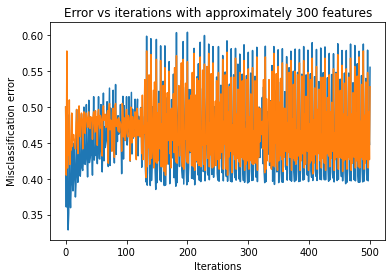

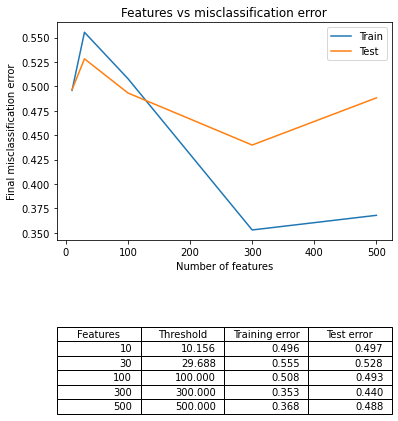

In [651]:
plot_tisp(train_x, train_y, test_x, test_y, [10.15625, 29.6875, 100, 300, 500]);
